In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.text import Text
import numpy as np
from scipy.special import gamma

from numpy.random import default_rng

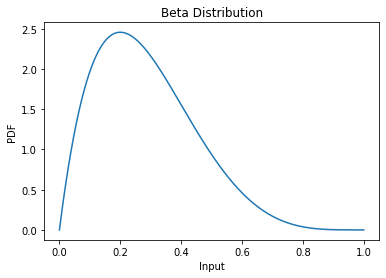

Known  1  Moment :  0.2857142857142857
Known  2  Moment :  0.025510204081632654
Known  3  Moment :  0.5962847939999439
Known  4  Moment :  -0.12


<Figure size 432x288 with 0 Axes>

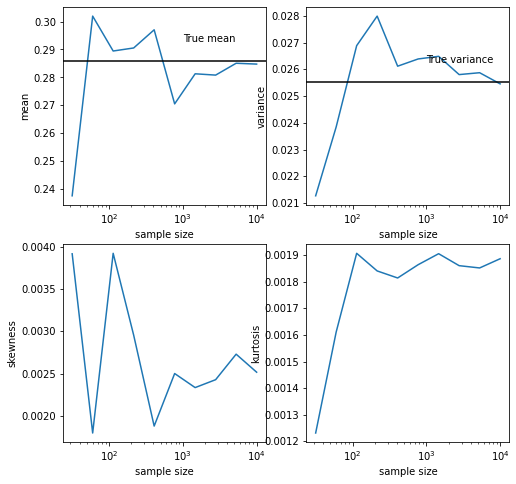

In [5]:
# https://en.wikipedia.org/wiki/Beta_distribution
class BetaDistribuiton:
    pow = np.float_power
    name = "Beta Distribution"

    def __init__(self, a, b) -> None:
        self.a = a
        self.b = b
    
    def A_1(self, in_pow):
        return self.pow(gamma(self.a)*gamma(self.b), in_pow)
    
    def A_2(self, in_float):
        return gamma(self.a + self.b + in_float)


    def B_1(self, in_float):
        return (self.a*self.b*in_float)
    
    def B_2(self, in_float):
        return (self.a + self.b + in_float)
    
    def B_3(self, in_float, in_power):
        return self.pow(self.a + self.b + in_float, in_power)
    
    
    def C_1(self, in_power):
        return self.pow(self.a - self.b, in_power)
    
    def C_2(self, in_power):
        return self.pow(self.b - self.a, in_power)

    def beta(self):
        return self.A_1(1) / self.A_2(0.)
    
    def pdf(self, in_x):
        return self.pow(in_x, self.a - 1.)*self.pow(1 - in_x, self.b - 1)/self.beta()

    def mean(self):
        return self.a / self.B_2(0)

    def variance(self):
        return self.B_1(1)/(self.B_3(0, 2) * self.B_2(1))

    def skewness(self):
        return (2.*self.C_2(1) * np.sqrt(self.a + self.b + 1)) / (self.B_2(2) * np.sqrt(self.a * self.b))

    def kurtosis(self):
        return 6*(self.C_1(2)*self.B_2(1) - self.B_1(1)*self.B_2(2)) / (self.B_1(1)*self.B_2(2)*self.B_2(3))

    def get_moment(self, n):
        if n == 1:
            return self.mean()
        elif n == 2:
            return self.variance()
        elif n == 3:
            return self.skewness()
        elif n == 4:
            return self.kurtosis()
        else:
            raise NotImplementedError("No other known moments!")

    def plot(self):
        fig, ax = plt.subplots()
        xs = np.linspace(0, 1, 1000)
        ys = self.pdf(xs)
        
        ax.plot(xs, ys)
        ax.set(title=self.name, xlabel="Input", ylabel="PDF")

        plt.show()
        plt.clf()

class Sampler:
    def __init__(self):
        self.ini_seed = 420
        self.mean = None
    
    def set_mean(self, in_val):
        self.mean = in_val

    def get_sample(self, size, entropy, *support):
        seed = int(self.ini_seed * (np.log2(size) + size) * entropy)
        return default_rng(seed).uniform(*support, int(size))

    def get_moment(self, dist, size, k):
        use_sample = self.get_sample(size, k, 0, 1)
        use_sample_2 = use_sample.copy()
        if k > 1:
            use_sample_2 = use_sample_2 - self.mean
        return np.sum(np.float_power(use_sample_2, k) * dist.pdf(use_sample))/len(use_sample)


beta_dist = BetaDistribuiton(2., 5.)
sampler = Sampler()
beta_dist.plot()

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
moment_name = ["mean", "variance", "skewness", "kurtosis"]
for m_i, m_k in enumerate(range(1, 5)):
    true_moment = beta_dist.get_moment(m_k)
    print("Known ", m_k, " Moment : ", true_moment)
    x_s = list(np.logspace(1.5, 4, 10))
    y_s = [sampler.get_moment(beta_dist, s_size, m_k) for s_size in x_s]
    if m_i == 0:
        sampler.set_mean(y_s[-1])
    
    
    ax_col = m_i % 2
    ax_row = m_i // 2
    
    cur_ax = axs[ax_row][ax_col]
    cur_ax.plot(x_s, y_s)
    cur_ax.set_xscale("log")
    cur_ax.set_xlabel("sample size")
    cur_ax.set_ylabel(moment_name[m_i])
    # cur_ax.set_ylim([0, 1])
    
    y_min, y_max = cur_ax.get_ylim()
    y_off = abs(y_max - y_min) * 0.1
    true_line = Line2D([0, 10e4], [true_moment, true_moment], color="black")
    true_text = Text(10e2, true_moment + y_off, "True " + moment_name[m_i])
    cur_ax.add_artist(true_line)
    cur_ax.add_artist(true_text)
    